Importing Libraries

In [1]:
import pandas as pd
import pickle
import mlflow
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.layers import SimpleRNN, LSTM, Input, Dense
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Tracking Model
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('Weather Forcast 2')

<Experiment: artifact_location='./mlruns/2', creation_time=1676755213648, experiment_id='2', last_update_time=1676755213648, lifecycle_stage='active', name='Weather Forcast 2', tags={}>

In [7]:
mlflow.artifacts.download_artifacts(run_id = 'b64289fe2b6b468b958369ad0514f8f3' , artifact_path= 'feature/dv.bin')

'c:\\Users\\Godwin\\Documents\\Workflow\\Project\\Weather\\mlruns\\2\\b64289fe2b6b468b958369ad0514f8f3\\artifacts\\feature\\dv.bin'

In [2]:
def load_data(path):
    data = pd.read_csv(path)
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    cat_col = data.dtypes[data.dtypes == 'object'].index.tolist()

    for col in cat_col:
        data[col] = data[col].str.lower().str.replace(' ', '_')
    return data

data = load_data('./weatherAUS.csv')
data['date'] = pd.to_datetime(data['date'])

num_col = data.dtypes[data.dtypes == 'float64'].index.tolist()
cat_col = data.dtypes[data.dtypes == 'object'].index.tolist()

for col in num_col:
        data[col] = data[col].interpolate(method='linear')
for col in num_col:
        data[col] = data[col].fillna(data[col].mean())

for col in cat_col:
        data[col] = data[col].fillna(data[col].mode()[0])

label = (data['raintomorrow'] == 'yes').astype('int')

In [4]:
plt.figure(figsize =  (16,10))
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

In [5]:
plt.figure(figsize=(16,15))
row = int((len(num_col)/4) + 1)

for i,col in enumerate(num_col):
    plt.subplot(row, 4, i+1)
    plt.hist(data[col])
    plt.xlabel(col)

df = data.copy()
df['evaporation'] = np.log1p(df['evaporation'])
df['rainfall'] = np.log1p(df['rainfall'])

In [6]:
plt.figure(figsize=(25,20))
row = int(len(num_col)/4) + 1

for i,col in enumerate(num_col):
    plt.subplot(row,4, i+1)
    #data = train_data.groupby(['location'])[col].mean().sort_values(ascending = False).head(10)
    sns.boxplot(x = 'raintomorrow', y = col, data = data)
    plt.ylabel(col)
    plt.xticks(rotation = 45)

In [7]:
def split_data(df):


    locations = [x for x in df.location.unique()]

    full_train_df = pd.DataFrame(columns=df.columns)
    full_val_df = pd.DataFrame(columns=df.columns)

    for i in locations:
        curr_data = df[df.location == i]
        no_datapoint = curr_data.shape[0]
        train_size = int(0.8 * no_datapoint)
        training_data, val_data = curr_data[:train_size], curr_data[train_size:]
        full_train_df = pd.concat([full_train_df, training_data])
        full_val_df = pd.concat([full_val_df, val_data])

    train_data = full_train_df.reset_index(drop = True)
    val_data = full_val_df.reset_index(drop = True)
    
    y_train = (train_data['raintomorrow'] == 'yes').astype('int')
    y_val = (val_data['raintomorrow'] == 'yes').astype('int')

    del train_data['raintomorrow']
    del val_data['raintomorrow']

    # train_size = int(0.8 * df.shape[0])
    # training_data, val_data = df[:train_size], df[train_size:]
    # train_data = training_data.reset_index(drop = True)
    # val_data = val_data.reset_index(drop = True)

    # y_train = (train_data['raintomorrow'] == 'yes')#.astype('int')
    # y_val = (val_data['raintomorrow'] == 'yes')#.astype('int')

    # del train_data['raintomorrow']
    # del val_data['raintomorrow']

    return train_data, val_data,y_train, y_val

In [168]:
def encoding(train_data, val_data):

    features = [x for x in train_data.columns]
    text = 'Feature Names: '
    for col in features:
        text = text + col +', '
        
    cat_col = train_data.dtypes[train_data.dtypes == 'object'].index.tolist()
    num_col = train_data.dtypes[train_data.dtypes == 'float64'].index.tolist()

    dv = DictVectorizer(sparse = False)
    dv.fit(train_data[cat_col + num_col].to_dict(orient = 'records'))
    feature_names = dv.get_feature_names()

    

    X_train = dv.transform(train_data[cat_col + num_col].to_dict(orient = 'records'))
    X_val = dv.transform(val_data[cat_col + num_col].to_dict(orient = 'records'))

    return X_train, X_val, text, dv

In [183]:
def xg_boost(x_train,y_train,x_val,y_val):

    dtrain = xgb.DMatrix(x_train, label = y_train)
    dval = xgb.DMatrix(x_val, label = y_val)

    x_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'n_threads':5,

    'seed':1,
    'verbosity':0
    }

    model = xgb.train(x_params, dtrain = dtrain,num_boost_round = 10)

    pred = model.predict(dval)
    auc = roc_auc_score(y_val,pred)

    out = (pred >= 0.5).astype('int')
    acc =  accuracy_score(y_val, out)
    precision = precision_score(y_val,out)
    recall = recall_score(y_val, out)
    f1 = f1_score(y_val, out)

    return ['xgb', acc, auc, precision,recall,f1, model]

def modeling(x_train, y_train,x_val, y_val, feature_names, dv):
    
    models = [LogisticRegression(), 
                DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 5),
                RandomForestClassifier(n_estimators = 10, max_depth = 10, min_samples_split = 7, min_samples_leaf = 5)]

    scores = []
    names = ['LogisticRegression', 'DecisionTree', 'RandomForest']
    for i,model in enumerate(models):
        with mlflow.start_run():
            # mlflow.log_param('params',model)
            model = model.fit(x_train, y_train)
            mlflow.sklearn.log_model(model, names[i])
            prediction = model.predict(x_val)
            acc = accuracy_score(y_val, prediction)
            auc = roc_auc_score(y_val, prediction)
            precision = precision_score(y_val, prediction)
            recall = recall_score(y_val, prediction)
            f1 = f1_score(y_val, prediction)
            mlflow.log_metric('accuracy', acc)
            mlflow.log_metric('auc', auc)
            mlflow.log_metric('precision', precision)
            mlflow.log_metric('recall', recall)
            mlflow.log_metric('f1-score', f1)

            if not os.path.isfile('feature.txt'):
                with open('feature.txt', 'w') as f_in:
                    f_in.write(feature_names)
                mlflow.log_artifact('feature.txt', 'feature')
            os.remove('feature.txt')
            with open('dv.bin', 'wb') as f:
                pickle.dump(dv, f)
            mlflow.log_artifact('dv.bin', 'feature')
            os.remove('dv.bin')

        
        scores.append([names[i], acc,auc, precision, recall, f1])
    name, acc, auc, precision, recall, f1, model = xg_boost(x_train, y_train, x_val,y_val)

    mlflow.start_run()
    if not os.path.isfile('feature.txt'):
        with open('feature.txt', 'w') as f_in:
            f_in.write(feature_names)
        mlflow.log_artifact('feature.txt', 'feature')
        os.remove('feature.txt')
        with open('dv.bin', 'wb') as f:
            pickle.dump(dv, f)
        mlflow.log_artifact('dv.bin', 'feature')
        os.remove('dv.bin')
        
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('auc', auc)
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('f1-score', f1)
    mlflow.xgboost.log_model(model, 'xgb_model')
    mlflow.end_run()
    
    scores.append([name, acc,auc, precision, recall, f1])


   
    output = pd.DataFrame(scores, columns = ['model','accuracy_score', 'auc_score','precision_score', 'recall_score', 'f1_score'])
    return output

In [170]:
def training(data):
    train_data, val_data,y_train, y_val = split_data(data)
    X_train, X_val, feature_names, dv  = encoding(train_data, val_data)
    output = modeling(X_train, y_train, X_val, y_val, feature_names, dv)
    return output

In [11]:
output = training(data)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.832938,0.689036,0.692712,0.432120,0.532230
1,DecisionTree,0.831907,0.696115,0.675506,0.453679,0.542804
2,RandomForest,0.831255,0.660081,0.744423,0.354476,0.480262
3,xgb,0.842181,0.849110,0.718041,0.465084,0.564521


In [15]:
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day

output = training(data)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.834656,0.699504,0.685761,0.458210,0.549354
1,DecisionTree,0.831873,0.696037,0.675430,0.453523,0.542668
2,RandomForest,0.831667,0.662084,0.742414,0.359319,0.484262
3,xgb,0.841322,0.849967,0.718024,0.458678,0.559771


In [14]:
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
#data.drop('day', axis = 1, inplace =  True)

output = training(data)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.834313,0.700237,0.682712,0.460865,0.550270
1,DecisionTree,0.831907,0.696115,0.675506,0.453679,0.542804
2,RandomForest,0.833969,0.664401,0.756289,0.361662,0.489326
3,xgb,0.841288,0.850002,0.718919,0.457116,0.558877


In [16]:
#data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
#data.drop('day', axis = 1, inplace =  True)
data.drop('year', axis = 1, inplace =  True)

output = training(data)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.834897,0.686870,0.709229,0.422590,0.529613
1,DecisionTree,0.831873,0.696037,0.675430,0.453523,0.542668
2,RandomForest,0.834416,0.668669,0.747962,0.372754,0.497550
3,xgb,0.841150,0.849683,0.718642,0.456491,0.558326


In [17]:
corr_col = ['mintemp', 'pressure9am', 'temp9am', 'temp3pm', 'humidity9am', 'windspeed3pm']
df = data.drop(corr_col, axis = 1)

output = training(df)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.833557,0.683992,0.705898,0.416966,0.524258
1,DecisionTree,0.831736,0.692920,0.679304,0.445087,0.537801
2,RandomForest,0.823283,0.632368,0.754244,0.291517,0.420507
3,xgb,0.840807,0.845402,0.724593,0.445555,0.551804


In [18]:
df = data.copy()
df['temp_diff'] = df['maxtemp'] - df['mintemp']
df['pressure_diff'] = df['pressure3pm'] - df['pressure9am']
df['temp_time_diff'] = df['temp3pm'] - df['temp9am']
df['cloud_diff'] = df['cloud3pm'] - df['cloud9am']
df['wind_speed_diff'] = df['windspeed3pm'] - df['windspeed9am']
df['humidity_diff'] = df['humidity3pm'] - df['humidity9am']

output = training(df)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.835550,0.690429,0.706680,0.431339,0.535700
1,DecisionTree,0.832732,0.694344,0.682805,0.447274,0.540495
2,RandomForest,0.836993,0.671611,0.762101,0.376347,0.503869
3,xgb,0.840979,0.850642,0.714597,0.461178,0.560577


<AxesSubplot: >

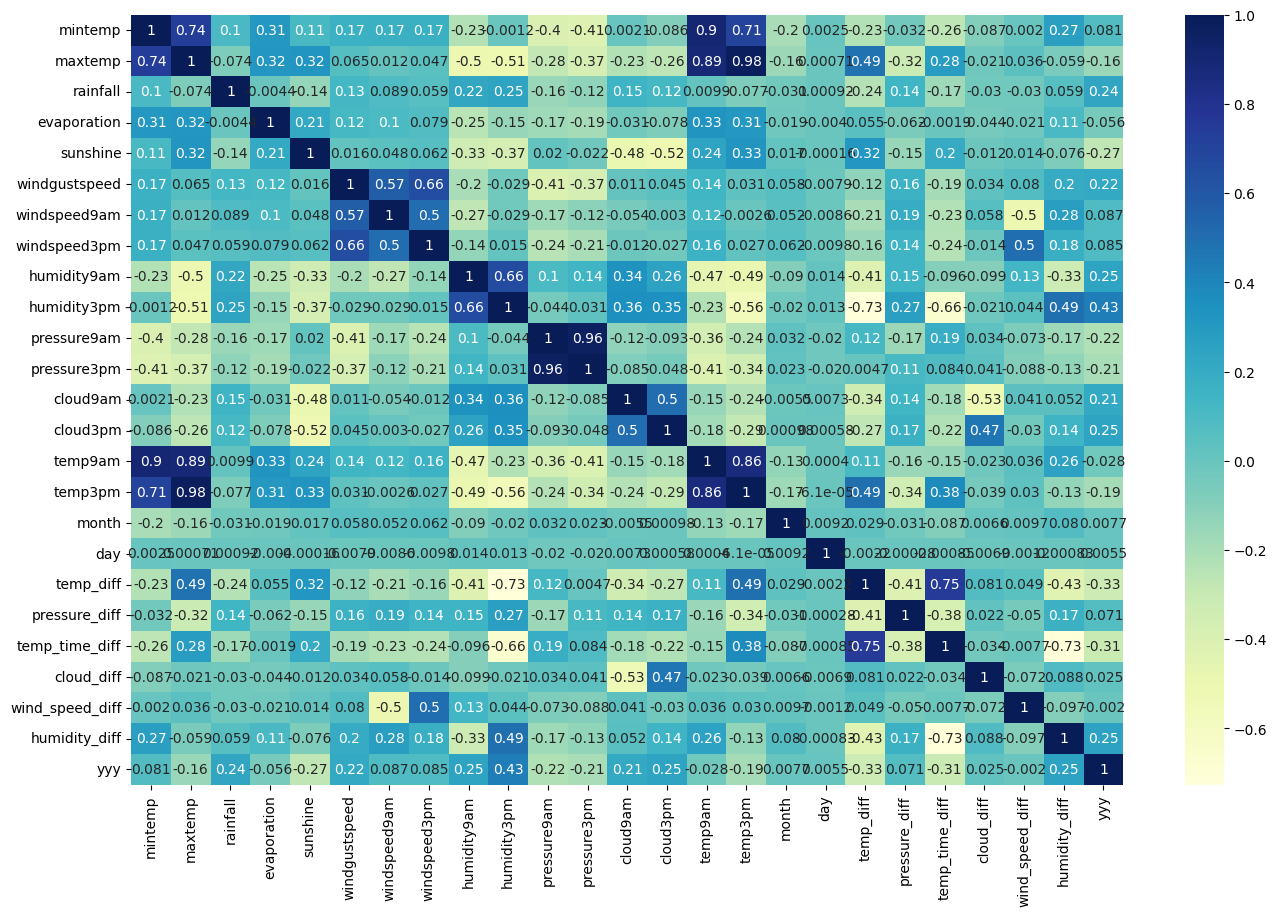

In [19]:
y_train = (df['raintomorrow'] == 'yes').astype('int')
df1 = df.copy()
df1['yyy'] = y_train

plt.figure(figsize =  (16,10))
sns.heatmap(df1.corr(), cmap="YlGnBu", annot=True)

In [20]:
corr_col = ['mintemp', 'pressure9am', 'temp9am', 'temp3pm', 'humidity9am', 'windspeed3pm']
df2 = df.drop(corr_col, axis = 1)

output = training(df2)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.834656,0.686828,0.707712,0.422903,0.529435
1,DecisionTree,0.833866,0.693557,0.690697,0.443056,0.539831
2,RandomForest,0.835137,0.667281,0.758298,0.367599,0.495160
3,xgb,0.840841,0.847762,0.719098,0.453523,0.556237


In [21]:
df4 = df[['rainfall', 'sunshine', 'windgustspeed', 'humidity9am', 'humidity3pm',
          'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp_diff', 'raintoday', 'location', 'raintomorrow']]

output = training(df4)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.833969,0.683190,0.710265,0.413998,0.523095
1,DecisionTree,0.833316,0.689895,0.693556,0.433838,0.533782
2,RandomForest,0.832663,0.668780,0.733029,0.376191,0.497212
3,xgb,0.841700,0.846039,0.726630,0.449305,0.555266


In [24]:
df4['monthly_bins'] = pd.cut(x = df1['month'], bins = [0, 3, 6, 9, 12], labels = ['0 - 3', '3 - 6', '6 - 9', '9 - 12'])
output = training(df4)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.833969,0.683190,0.710265,0.413998,0.523095
1,DecisionTree,0.833316,0.689895,0.693556,0.433838,0.533782
2,RandomForest,0.836752,0.678861,0.740385,0.396969,0.516831
3,xgb,0.841700,0.846039,0.726630,0.449305,0.555266


In [30]:
train_data, val_data,y_train, y_val = split_data(data)


undersample = RandomUnderSampler(sampling_strategy=0.3)

y = y_train.copy()
X_train, y = undersample.fit_resample(train_data, y)

X_train, X_val, feature_names = encoding(train_data, val_data)
output = modeling(X_train, y_train, X_val, y_val, feature_names)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.834897,0.686870,0.709229,0.422590,0.529613
1,DecisionTree,0.831873,0.696037,0.675430,0.453523,0.542668
2,RandomForest,0.827406,0.648528,0.742948,0.329167,0.456209
3,xgb,0.841150,0.849683,0.718642,0.456491,0.558326


In [31]:
train_data, val_data,y_train, y_val = split_data(df4)


undersample = RandomUnderSampler(sampling_strategy=0.3)

y = y_train.copy()
X_train, y = undersample.fit_resample(train_data, y)

X_train, X_val, feature_names = encoding(train_data, val_data)
output = modeling(X_train, y_train, X_val, y_val, feature_names)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.833969,0.683190,0.710265,0.413998,0.523095
1,DecisionTree,0.833316,0.689895,0.693556,0.433838,0.533782
2,RandomForest,0.835172,0.678128,0.729931,0.397750,0.514916
3,xgb,0.841700,0.846039,0.726630,0.449305,0.555266


In [32]:
oversample = SMOTE()

y = y_train.copy()
X_train, y = oversample.fit_resample(X_train, y)

X_train, X_val, feature_names = encoding(train_data, val_data)
output = modeling(X_train, y_train, X_val, y_val, feature_names)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.833969,0.683190,0.710265,0.413998,0.523095
1,DecisionTree,0.833385,0.690051,0.693709,0.434151,0.534064
2,RandomForest,0.831151,0.666970,0.725371,0.373848,0.493402
3,xgb,0.841700,0.846039,0.726630,0.449305,0.555266


In [33]:
X_train.shape

(116357, 61)

In [46]:
xx_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [82]:
model.save('lstm.h5', save_format = 'h5')

In [84]:
def fearure_engineering(df):
    
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['day'] = pd.DatetimeIndex(df['date']).day
   
    df['temp_diff'] = df['maxtemp'] - df['mintemp']
    df['pressure_diff'] = df['pressure3pm'] - df['pressure9am']
    df['temp_time_diff'] = df['temp3pm'] - df['temp9am']
    df['cloud_diff'] = df['cloud3pm'] - df['cloud9am']
    df['wind_speed_diff'] = df['windspeed3pm'] - df['windspeed9am']
    df['humidity_diff'] = df['humidity3pm'] - df['humidity9am']
    corr_col = ['mintemp', 'pressure9am', 'temp9am', 'temp3pm', 'humidity9am', 'windspeed3pm']
    df = df.drop(corr_col, axis = 1)
    return df

data = fearure_engineering(data)
print(data.shape)
data.head()

(145460, 25)


,date,location,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,...,raintoday,raintomorrow,month,day,temp_diff,pressure_diff,temp_time_diff,cloud_diff,wind_speed_diff,humidity_diff
0,2008-12-01,albury,22.9,0.6,6.534638,7.649576,w,44.0,w,wnw,...,no,no,12,1,9.5,-0.6,4.9,-3.381443,4.0,-49.0
1,2008-12-02,albury,25.1,0.0,6.534638,7.649576,wnw,44.0,nnw,wsw,...,no,no,12,2,17.7,-2.8,7.1,-3.131443,18.0,-19.0
2,2008-12-03,albury,25.7,0.0,6.534638,7.649576,wsw,46.0,w,wsw,...,no,no,12,3,12.8,1.1,2.2,-5.500000,7.0,-8.0
3,2008-12-04,albury,28.0,0.0,6.534638,7.649576,ne,24.0,se,e,...,no,no,12,4,18.8,-4.8,8.4,-2.250000,-2.0,-29.0
4,2008-12-05,albury,32.3,1.0,6.534638,7.649576,w,41.0,ene,nw,...,no,no,12,5,14.8,-4.8,11.9,1.000000,13.0,-49.0


<AxesSubplot: >

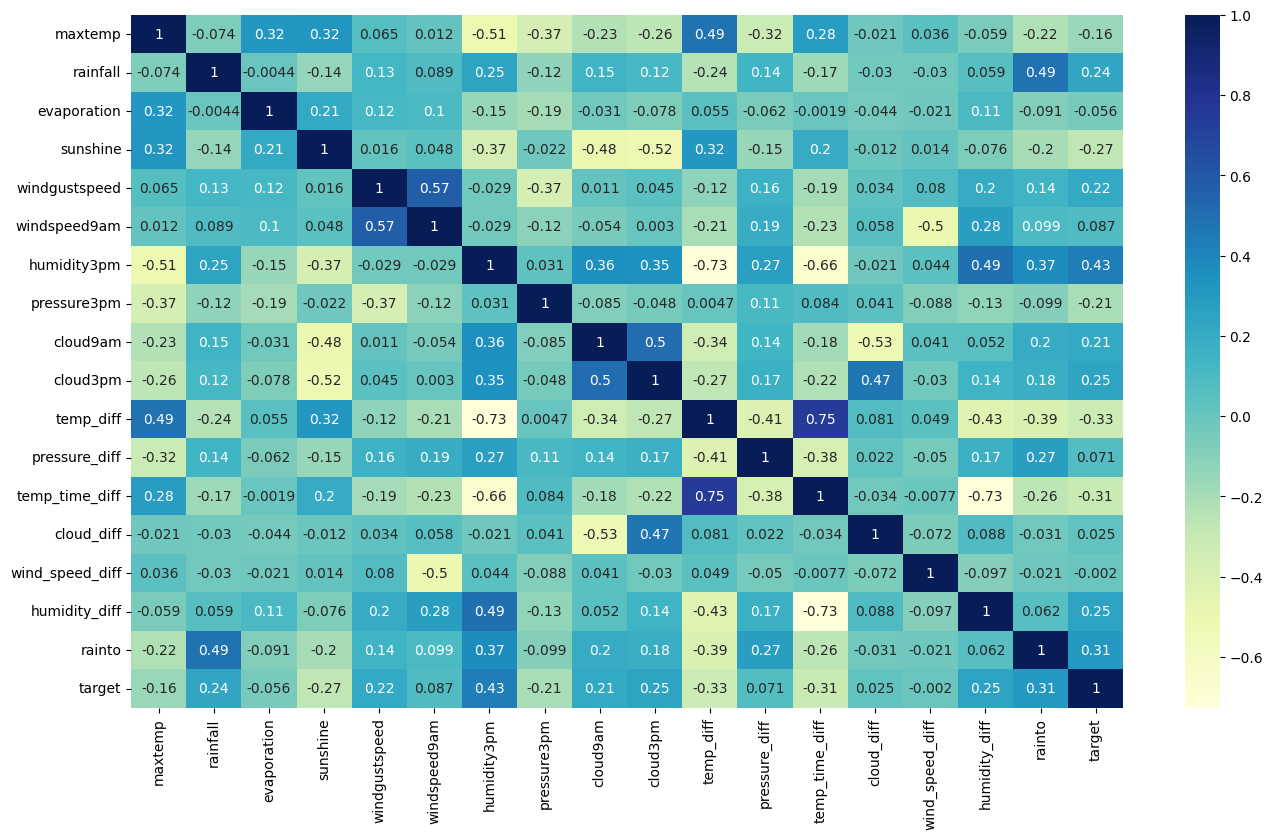

In [113]:
plt.figure(figsize=(16,9))
df = data.copy()
df['rainto'] = (df['raintoday'] == 'yes').astype('int')
df['target'] = (df['raintomorrow'] == 'yes').astype('int')
num_col = df.dtypes[df.dtypes == 'float64'].index.tolist()
num_col.extend(['rainto', 'target'])
sns.heatmap(df[num_col].corr(), cmap="YlGnBu", annot=True )

In [153]:
corr_col = ['rainfall', 'sunshine', 'windgustspeed', 'pressure3pm','cloud3pm',
             'humidity3pm', 'temp_diff', 'raintoday', 'raintomorrow', 'location',
             'humidity_diff']
#data['rainfall'] = np.log1p(df['rainfall'])
df = data[corr_col]
output = training(df)
output

In [146]:
train_data, val_data,y_train, y_val = split_data(df)


undersample = RandomUnderSampler(sampling_strategy=0.3)

y = y_train.copy()
X_train, y = undersample.fit_resample(train_data, y)

X_train, X_val, feature_names = encoding(X_train, val_data)
output = modeling(X_train, y, X_val, y_val, feature_names)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.834278,0.688381,0.702308,0.427902,0.531793
1,DecisionTree,0.829708,0.694930,0.665294,0.454304,0.539918
2,RandomForest,0.834897,0.672287,0.742259,0.381972,0.504384
3,xgb,0.841494,0.843929,0.718155,0.459772,0.560625


In [184]:
train_data, val_data,y_train, y_val = split_data(df)
oversample = SMOTE()

y = y_train.copy()

X_train, X_val, feature_names, dv = encoding(train_data, val_data)
X_train, y = oversample.fit_resample(X_train, y)

output = modeling(X_train, y, X_val, y_val, feature_names, dv)
output

,model,accuracy_score,auc_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.758822,0.746246,0.468737,0.723793,0.568990
1,DecisionTree,0.795726,0.718523,0.532674,0.580691,0.555647
2,RandomForest,0.805415,0.737859,0.551508,0.617247,0.582529
3,xgb,0.802873,0.834881,0.544149,0.639275,0.587889
